# Abstract
## This notebook thoroughly explores and utilizes all features present in the dataset, test the model using test images to evaluate models performance.
---

## Objective
### - Exploration of All Features:
use all features as reference to see how performance can be affected by feature selection after this.

### - Regression Modeling:
implement regression models for pose prediction, to find the best fitted model for this problem with its highly dimensional features.
1. Linear Regression.
2. Ridge Regression.
3. Lasso Regression.
4. Support Vector Regression.
5. K-Nearest Neighbors Regression.
6. Huber Regression.
7. Decision Tree Regressor


### - Hyperparameter Tuning:
employ hyperparameter tuning techniques for each model to optimize its performance using Optuna.

### - Evaluation and Comparison of Models:
evaluate the performance of different regression models, comparing their effectiveness in head pose estimation tasks.

---

## Output
**Best fitted model for this problem by using all features.**
---

### import important libraries

In [ ]:
%%capture
!pip install mediapipe

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.1 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

###loading the dataset

In [ ]:
df = pd.read_csv('/content/face_landmarks.csv')
df

,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,...,y_464,x_465,y_465,x_466,y_466,x_467,y_467,pitch,yaw,roll
0,-121,139,-12,37,-109,70,-61,-86,0,0,...,-197,-90,-186,-42,-228,-37,-253,-1.108159,-1.443685,1.129171
1,52,100,7,24,43,35,-8,-75,0,0,...,-182,92,-169,275,-223,292,-244,-0.373085,0.293578,-0.125011
2,0,79,0,23,0,29,-24,-77,0,0,...,-189,46,-176,212,-244,223,-254,-0.474087,-0.040907,0.019801
3,-37,94,-4,29,-23,48,-26,-76,0,0,...,-147,26,-141,165,-161,177,-164,-0.116700,-0.233745,0.095809
4,-94,139,-8,35,-98,70,-70,-77,0,0,...,-190,-118,-178,-87,-232,-85,-247,-0.379067,-0.985426,0.086955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,-77,129,-9,31,-66,56,-45,-79,0,0,...,-182,-38,-171,48,-224,55,-238,-0.266459,-0.722653,0.219750
1849,7,105,-1,29,7,48,-11,-77,0,0,...,-158,81,-151,261,-180,275,-190,-0.161717,0.085792,0.027202
1850,52,114,2,30,43,59,6,-65,0,0,...,-134,119,-129,300,-158,322,-168,-0.046365,0.580349,-0.023616
1851,-6,134,2,27,-12,70,-38,-50,0,0,...,-114,0,-109,115,-144,125,-164,-0.948136,-1.241852,1.234426


### Features-labels split and train-validation-test split

In [ ]:
labels = df[['pitch', 'yaw', 'roll']]
Pitch = df[['pitch']]
Yaw = df[['yaw']]
Roll = df[['roll']]
features = df.drop(['pitch', 'yaw', 'roll'], axis=1)

In [ ]:
x_train, x_validation, y_train, y_validation = train_test_split(features, labels, test_size=0.2, random_state=42)
x_train, x_validation, pitch_train, pitch_validation = train_test_split(features, Pitch, test_size=0.2, random_state=42)
x_train, x_validation, yaw_train, yaw_validation = train_test_split(features, Yaw, test_size=0.2, random_state=42)
x_train, x_validation, roll_train, roll_validation = train_test_split(features, Roll, test_size=0.2, random_state=42)

## Get the best parameters for each regression model using Optuna

**Optuna is a hyperparameter optimization framework designed to automate the process of tuning machine learning model parameters.** <br>[see Optuna docs](https://optuna.org/)<br>

note: multi Output Regressor were used to find the best optimized model
without making 3 medels at the beginning for code simplicity.
<br>
<br>
<br>

- Linear Regression.

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    positive = trial.suggest_categorical('positive', [True, False])
    n_jobs = trial.suggest_categorical('n_jobs', [-1, 1, 2])

    # Create Linear Regression model
    lr = LinearRegression(fit_intercept=fit_intercept, positive=positive, n_jobs=n_jobs)

    # Create MultiOutputRegressor
    multi_out_lr = MultiOutputRegressor(lr)

    # Fit the model
    multi_out_lr.fit(x_train, y_train)

    # Calculate validation RMSE
    validation_rmse = np.sqrt(mean_squared_error(y_validation, multi_out_lr.predict(x_validation)))

    return validation_rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and their corresponding objective value
best_params = study.best_params
best_rmse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation RMSE:", best_rmse)


[I 2024-05-14 21:13:57,084] A new study created in memory with name: no-name-d4b1d2e5-3b0a-4dc7-b8e3-b35bccb3c8a3
[I 2024-05-14 21:13:57,626] Trial 0 finished with value: 0.17409961633308216 and parameters: {'fit_intercept': False, 'positive': True, 'n_jobs': 2}. Best is trial 0 with value: 0.17409961633308216.
[I 2024-05-14 21:13:58,055] Trial 1 finished with value: 0.17850345851417956 and parameters: {'fit_intercept': True, 'positive': True, 'n_jobs': 2}. Best is trial 0 with value: 0.17409961633308216.
[I 2024-05-14 21:14:00,795] Trial 2 finished with value: 0.5753094985516624 and parameters: {'fit_intercept': False, 'positive': False, 'n_jobs': -1}. Best is trial 0 with value: 0.17409961633308216.
[I 2024-05-14 21:14:01,476] Trial 3 finished with value: 0.17409961633308216 and parameters: {'fit_intercept': False, 'positive': True, 'n_jobs': -1}. Best is trial 0 with value: 0.17409961633308216.
[I 2024-05-14 21:14:05,781] Trial 4 finished with value: 0.5753094985516624 and parameter

Best Hyperparameters: {'fit_intercept': False, 'positive': True, 'n_jobs': 2}
Best Validation RMSE: 0.17409961633308216


- Ridge Regression.

In [ ]:
def objective(trial):
    # Define hyperparameters to tune
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e3)
    solver = trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    # Create Ridge Regression model
    ridge = Ridge(alpha=alpha, fit_intercept=fit_intercept, solver=solver, max_iter=max_iter)

    # Create MultiOutputRegressor
    multi_out_ridge = MultiOutputRegressor(ridge)

    # Fit the model
    multi_out_ridge.fit(x_train, y_train)

    # Calculate validation RMSE
    validation_rmse = np.sqrt(mean_squared_error(y_validation, multi_out_ridge.predict(x_validation)))

    return validation_rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and their corresponding objective value
best_params = study.best_params
best_rmse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation RMSE:", best_rmse)

[I 2024-05-14 21:17:24,158] A new study created in memory with name: no-name-80230052-1ebe-48dc-9307-32e46c81417f
[I 2024-05-14 21:17:27,078] Trial 0 finished with value: 0.5200680834517775 and parameters: {'fit_intercept': True, 'alpha': 0.005982259552653154, 'solver': 'sparse_cg', 'max_iter': 624}. Best is trial 0 with value: 0.5200680834517775.
[I 2024-05-14 21:17:28,077] Trial 1 finished with value: 0.3782088379140743 and parameters: {'fit_intercept': True, 'alpha': 0.7025411983772987, 'solver': 'lsqr', 'max_iter': 344}. Best is trial 1 with value: 0.3782088379140743.
[I 2024-05-14 21:18:24,994] Trial 2 finished with value: 0.20337859865660513 and parameters: {'fit_intercept': False, 'alpha': 0.016335984821711936, 'solver': 'sag', 'max_iter': 935}. Best is trial 2 with value: 0.20337859865660513.
[I 2024-05-14 21:18:25,605] Trial 3 finished with value: 0.573751451270347 and parameters: {'fit_intercept': False, 'alpha': 0.0881284134287474, 'solver': 'cholesky', 'max_iter': 753}. Bes

Best Hyperparameters: {'fit_intercept': False, 'alpha': 23.9008758976244, 'solver': 'saga', 'max_iter': 100}
Best Validation RMSE: 0.15771807872662666


- Lasso Regression.

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e3)
    precompute = trial.suggest_categorical('precompute', [True, False])
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    # Create Lasso Regression model
    lasso = Lasso(alpha=alpha, fit_intercept=fit_intercept, precompute=precompute, max_iter=max_iter)

    # Create MultiOutputRegressor
    multi_out_lasso = MultiOutputRegressor(lasso)

    # Fit the model
    multi_out_lasso.fit(x_train, y_train)

    # Calculate validation RMSE
    validation_rmse = np.sqrt(mean_squared_error(y_validation, multi_out_lasso.predict(x_validation)))

    return validation_rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and their corresponding objective value
best_params = study.best_params
best_rmse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation RMSE:", best_rmse)

[I 2024-05-14 21:39:54,263] A new study created in memory with name: no-name-6911b9f7-7565-4d63-9c2c-a70b04eb8638
[I 2024-05-14 21:39:57,359] Trial 0 finished with value: 0.2324691619343756 and parameters: {'fit_intercept': True, 'alpha': 0.0162149647923817, 'precompute': False, 'max_iter': 836}. Best is trial 0 with value: 0.2324691619343756.
[I 2024-05-14 21:39:57,646] Trial 1 finished with value: 0.4159696358765429 and parameters: {'fit_intercept': True, 'alpha': 501.16478960708855, 'precompute': True, 'max_iter': 621}. Best is trial 0 with value: 0.2324691619343756.
[I 2024-05-14 21:39:58,884] Trial 2 finished with value: 0.2228663514679518 and parameters: {'fit_intercept': True, 'alpha': 0.002747659750434483, 'precompute': False, 'max_iter': 266}. Best is trial 2 with value: 0.2228663514679518.
[I 2024-05-14 21:39:59,186] Trial 3 finished with value: 0.2631448997092392 and parameters: {'fit_intercept': True, 'alpha': 29.16763307798467, 'precompute': True, 'max_iter': 566}. Best is

Best Hyperparameters: {'fit_intercept': False, 'alpha': 2.569692136308436, 'precompute': True, 'max_iter': 187}
Best Validation RMSE: 0.1422506184505868


- Support Vector Regression.

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    epsilon = trial.suggest_uniform('epsilon', 0.1, 1.0)

    # Create SVR model
    svr = SVR(kernel=kernel, C=C, gamma=gamma, epsilon=epsilon)

    # Create MultiOutputRegressor
    multi_out_svr = MultiOutputRegressor(svr)

    # Fit the model
    multi_out_svr.fit(x_train, y_train)

    # Calculate validation RMSE
    validation_rmse = np.sqrt(mean_squared_error(y_validation, multi_out_svr.predict(x_validation)))

    return validation_rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get the best hyperparameters and their corresponding objective value
best_params = study.best_params
best_rmse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation RMSE:", best_rmse)

[I 2024-05-16 08:37:58,983] A new study created in memory with name: no-name-15fc0a4b-43c3-4519-aa25-d3421e6298ae
[I 2024-05-16 08:47:01,543] Trial 3 finished with value: 0.6576735617133476 and parameters: {'kernel': 'linear', 'C': 0.17143933747901136, 'gamma': 'auto', 'epsilon': 0.8554498897205245}. Best is trial 2 with value: 0.16757059553594802.
[I 2024-05-16 08:51:36,346] Trial 0 finished with value: 0.6434529045841169 and parameters: {'kernel': 'linear', 'C': 396.14060885361096, 'gamma': 'scale', 'epsilon': 0.7982693252052453}. Best is trial 0 with value: 0.6434529045841169.
[I 2024-05-16 08:52:59,918] Trial 2 finished with value: 0.40054650594988145 and parameters: {'kernel': 'linear', 'C': 0.005830625635752866, 'gamma': 'auto', 'epsilon': 0.6979915951157304}. Best is trial 2 with value: 0.40054650594988145.
[I 2024-05-16 09:00:20,790] Trial 5 finished with value: 0.6201736811022602 and parameters: {'kernel': 'linear', 'C': 7.171598181938672, 'gamma': 'auto', 'epsilon': 0.7028857

KeyboardInterrupt: 

`although SVR make the best performance, it takes hours for tuning without converging.`

- K-Nearest Neighbors Regression.

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    # Create K-Nearest Neighbors Regression model
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)

    # Fit the model
    knn.fit(x_train, y_train)

    # Calculate validation RMSE
    validation_rmse = np.sqrt(mean_squared_error(y_validation, knn.predict(x_validation)))

    return validation_rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and their corresponding objective value
best_params = study.best_params
best_rmse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation RMSE:", best_rmse)

[I 2024-05-14 21:41:36,473] A new study created in memory with name: no-name-f7e9371e-3c54-41e6-9b6d-ae90084d9f87
[I 2024-05-14 21:41:36,619] Trial 0 finished with value: 0.6644110577363782 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'auto'}. Best is trial 0 with value: 0.6644110577363782.
[I 2024-05-14 21:41:37,527] Trial 1 finished with value: 0.1990651288025325 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.1990651288025325.
[I 2024-05-14 21:41:37,669] Trial 2 finished with value: 0.21214930004429242 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 1 with value: 0.1990651288025325.
[I 2024-05-14 21:41:37,865] Trial 3 finished with value: 0.18559501078179655 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 3 with value: 0.18559501078179655.
[I 2024-05-14 21:41:38,634] Trial 4 finished with value: 0.470

Best Hyperparameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto'}
Best Validation RMSE: 0.17520974462731873


- Huber Regression.

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    epsilon = trial.suggest_uniform('epsilon', 1.1, 2.0)
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e3)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    # Create Huber Regression model
    huber = HuberRegressor(epsilon=epsilon, alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter)

    # Create MultiOutputRegressor
    multi_out_huber = MultiOutputRegressor(huber)

    # Fit the model
    multi_out_huber.fit(x_train, y_train)

    # Calculate validation RMSE
    validation_rmse = np.sqrt(mean_squared_error(y_validation, multi_out_huber.predict(x_validation)))

    return validation_rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and their corresponding objective value
best_params = study.best_params
best_rmse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation RMSE:", best_rmse)

[I 2024-05-14 21:42:20,300] A new study created in memory with name: no-name-b4b2ab75-c3db-444f-95f4-a84fd6949b7f
[I 2024-05-14 21:42:44,240] Trial 0 finished with value: 0.33972122142145095 and parameters: {'epsilon': 1.5562637430543682, 'alpha': 0.47179832179447984, 'fit_intercept': True, 'max_iter': 623}. Best is trial 0 with value: 0.33972122142145095.
[I 2024-05-14 21:43:23,102] Trial 1 finished with value: 0.25960959044545173 and parameters: {'epsilon': 1.9496778596206077, 'alpha': 64.63533863576089, 'fit_intercept': True, 'max_iter': 843}. Best is trial 1 with value: 0.25960959044545173.
[I 2024-05-14 21:43:45,153] Trial 2 finished with value: 0.31791690374430276 and parameters: {'epsilon': 1.9662962002629385, 'alpha': 0.7886828817861505, 'fit_intercept': False, 'max_iter': 552}. Best is trial 1 with value: 0.25960959044545173.
[I 2024-05-14 21:44:19,218] Trial 3 finished with value: 0.2627858804933495 and parameters: {'epsilon': 1.379783692452868, 'alpha': 0.12638716563961447, 

Best Hyperparameters: {'epsilon': 1.986235054274329, 'alpha': 545.6228746307662, 'fit_intercept': True, 'max_iter': 103}
Best Validation RMSE: 0.1429986060385563



*   Decision Tree Regressor


In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Create Decision Tree Regressor model
    dt = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    # Create MultiOutputRegressor
    multi_out_dt = MultiOutputRegressor(dt)

    # Fit the model
    multi_out_dt.fit(x_train, y_train)

    # Calculate validation RMSE
    validation_rmse = np.sqrt(mean_squared_error(y_validation, multi_out_dt.predict(x_validation)))

    return validation_rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and their corresponding objective value
best_params = study.best_params
best_rmse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation RMSE:", best_rmse)

[I 2024-05-14 22:06:28,430] A new study created in memory with name: no-name-19d6e604-fac6-45a7-adee-e84795dd687d
[I 2024-05-14 22:06:32,023] Trial 0 finished with value: 0.26268089123219307 and parameters: {'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.26268089123219307.
[I 2024-05-14 22:06:32,941] Trial 1 finished with value: 0.3225292382808397 and parameters: {'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.26268089123219307.
[I 2024-05-14 22:06:33,560] Trial 2 finished with value: 0.32460418094886556 and parameters: {'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.26268089123219307.
[I 2024-05-14 22:06:36,037] Trial 3 finished with value: 0.2826072541855887 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.26268089123219307.
[I 2024-05-14 22:06:37,487] Trial 4 finished with value: 

Best Hyperparameters: {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 10}
Best Validation RMSE: 0.24325417079372694


#**Models Performace Evaluation Report**
### 1. Super Vector Regressor
`Best Hyperparameters:` {'kernel': 'rbf', 'C': 5.974424948536498, 'gamma': 'scale', 'epsilon': 0.22528390996663647} <br>
`Best Validation RMSE:` 0.13783541947397493
<br>
### 2. Lasso Regression
`Best Hyperparameters:` {'fit_intercept': False, 'alpha': 2.569692136308436, 'precompute': True, 'max_iter': 187} <br>
`Best Validation RMSE:` 0.1422506184505868
<br>
### 3. Huber Regression
`Best Hyperparameters:` {'epsilon': 1.986235054274329, 'alpha': 545.6228746307662, 'fit_intercept': True, 'max_iter': 103} <br>
`Best Validation RMSE:` 0.1429986060385563
<br>
### 4. Ridge Regression
`Best Hyperparameters:` {'fit_intercept': False, 'alpha': 23.9008758976244, 'solver': 'saga', 'max_iter': 100} <br>
`Best Validation RMSE:` 0.15771807872662666
<br>
### 5. linear regression
`Best Hyperparameters:` {'fit_intercept': False, 'positive': True, 'n_jobs': 2} <br>
`Best Validation RMSE:` 0.17409961633308216
<br>
### 6. K-Nearest Neighbors Regression
`Best Hyperparameters:` {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto'} <br>
`Best Validation RMSE:` 0.17520974462731873
<br>
### 7. Decision Tree Regressor
`Best Hyperparameters:` {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 10} <br>
`Best Validation RMSE:` 0.24325417079372694

# SVR Training

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

svr = SVR(kernel = 'rbf', C = 0.9370892038873868, gamma = 'scale', epsilon = 0.1783154242699071)
multi_out_svr = MultiOutputRegressor(svr).fit(x_train, y_train)


# Make predictions
y_pred_train = multi_out_svr.predict(x_train)
y_pred_validation = multi_out_svr.predict(x_validation)



# Evaluate the model
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_validation, y_pred_validation)


# Print evaluation metrics
print('Evaluation')
print("Root Mean Squared Error (RMSE) - Train: {:.4f}, Test: {:.4f}".format(rmse_train, rmse_test))
print("R-squared (R2) - Train: {:.4f}, Test: {:.4f}".format(r2_train, r2_test))

Evaluation
Root Mean Squared Error (RMSE) - Train: 0.4860, Test: 0.1298
R-squared (R2) - Train: 0.4310, Test: 0.8615


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

svr_pitch = SVR(kernel = 'rbf', C = 0.9370892038873868, gamma = 'scale', epsilon = 0.1783154242699071).fit(x_train, pitch_train)
svr_yaw = SVR(kernel = 'rbf', C = 0.9370892038873868, gamma = 'scale', epsilon = 0.1783154242699071).fit(x_train, yaw_train)
svr_roll = SVR(kernel = 'rbf', C = 0.9370892038873868, gamma = 'scale', epsilon = 0.1783154242699071).fit(x_train, roll_train)


# Make predictions
pitch_pred_train = svr_pitch.predict(x_train)
pitch_pred_test = svr_pitch.predict(x_test)

yaw_pred_train = svr_yaw.predict(x_train)
yaw_pred_test = svr_yaw.predict(x_test)

roll_pred_train = svr_roll.predict(x_train)
roll_pred_test = svr_roll.predict(x_test)

# Evaluate the model
rmse_train_pitch = np.sqrt(mean_squared_error(pitch_train, pitch_pred_train))
rmse_test_pitch = np.sqrt(mean_squared_error(pitch_test, pitch_pred_test))
r2_train_pitch = r2_score(pitch_train, pitch_pred_train)
r2_test_pitch = r2_score(pitch_test, pitch_pred_test)

rmse_train_yaw = np.sqrt(mean_squared_error(yaw_train, yaw_pred_train))
rmse_test_yaw = np.sqrt(mean_squared_error(yaw_test, yaw_pred_test))
r2_train_yaw = r2_score(yaw_train, yaw_pred_train)
r2_test_yaw = r2_score(yaw_test, yaw_pred_test)

rmse_train_roll = np.sqrt(mean_squared_error(roll_train, roll_pred_train))
rmse_test_roll = np.sqrt(mean_squared_error(roll_test, roll_pred_test))
r2_train_roll = r2_score(roll_train, roll_pred_train)
r2_test_roll = r2_score(roll_test, roll_pred_test)


# Print evaluation metrics
print('Pitch Evaluation')
print("Root Mean Squared Error (RMSE) - Train: {:.4f}, Test: {:.4f}".format(rmse_train_pitch, rmse_test_pitch))
print("R-squared (R2) - Train: {:.4f}, Test: {:.4f}".format(r2_train_pitch, r2_test_pitch))
print('\n')
print('Yaw Evaluation')
print("Root Mean Squared Error (RMSE) - Train: {:.4f}, Test: {:.4f}".format(rmse_train_yaw, rmse_test_yaw))
print("R-squared (R2) - Train: {:.4f}, Test: {:.4f}".format(r2_train_yaw, r2_test_yaw))
print('\n')
print('Roll Evaluation')
print("Root Mean Squared Error (RMSE) - Train: {:.4f}, Test: {:.4f}".format(rmse_train_roll, rmse_test_roll))
print("R-squared (R2) - Train: {:.4f}, Test: {:.4f}".format(r2_train_roll, r2_test_roll))

Pitch Evaluation
Root Mean Squared Error (RMSE) - Train: 0.4869, Test: 0.6973
R-squared (R2) - Train: 0.2026, Test: 0.0939


Yaw Evaluation
Root Mean Squared Error (RMSE) - Train: 0.1637, Test: 0.3652
R-squared (R2) - Train: 0.9139, Test: 0.6813


Roll Evaluation
Root Mean Squared Error (RMSE) - Train: 0.4836, Test: 0.8620
R-squared (R2) - Train: 0.3350, Test: 0.2125


## testing the model on photos

In [ ]:
def draw_axes(img, pitch,yaw,roll, center_point, size = 100):

    yaw = -yaw

    if center_point is None:
        height, width = img.shape[:2]
        center_point = (width / 2, height / 2)

    tdx, tdy = center_point

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [ ]:
def axes_prediction(img_path):
    data = []

    faceModule = mediapipe.solutions.face_mesh

    # Loading the image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Creating a FaceMesh instance
    with faceModule.FaceMesh(static_image_mode=True) as faces:

        # Processing the face to extract the landmark points for x, y
        results = faces.process(image)

        # Checking if there are multiple face landmarks detected
        if results.multi_face_landmarks:

            # Looping over the faces in the image
                  for idx, lm in enumerate(results.multi_face_landmarks[0].landmark):
                    if idx == 4:
                      nose_x = lm.x
                      nose_y = lm.y

                    if idx == 291:
                      lower_x = lm.x
                      lower_y = lm.y

                    if idx == 33:
                      upper_x = lm.x
                      upper_y = lm.y

                  distance_x = upper_x - lower_x
                  distance_y = upper_y - lower_y
                  distance = np.sqrt(distance_x**2 + distance_y**2)
                  for face in results.multi_face_landmarks:
                      for landmark in face.landmark:
                          x = (landmark.x - nose_x) / distance
                          y = (landmark.y - nose_y) / distance
                          shape = image.shape
                          x = int(x * shape[1])
                          y = int(y * shape[0])
                          data.extend([x, y])


    data
    dd = np.array(data)
    dd = dd.reshape(1,-1)

    # pitch = svr_pitch.predict(dd)
    # yaw = svr_yaw.predict(dd)
    # roll = svr_roll.predict(dd)
    pitch, yaw, roll = multi_out_svr.predict(dd).ravel()

    h, w, c = image.shape
    center_point = (nose_x * w, nose_y * h)

    cv2_imshow(draw_axes(image, pitch, yaw, roll, center_point))

    return

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


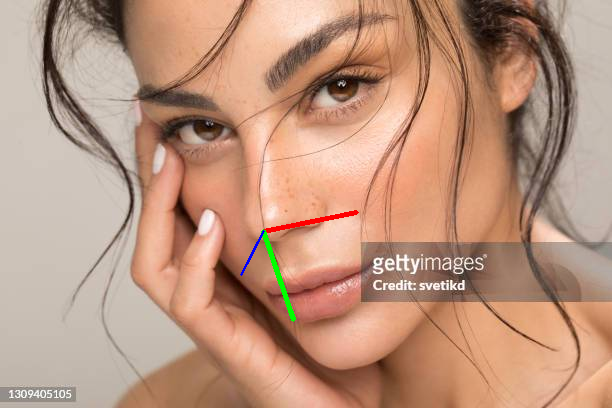

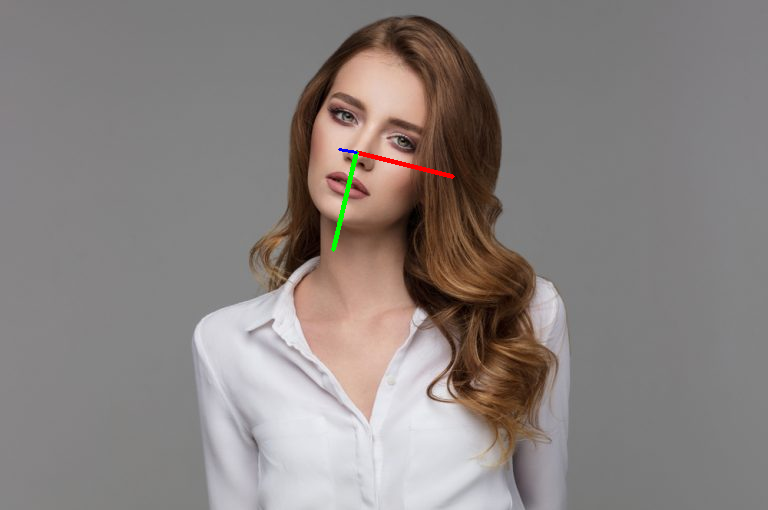

In [ ]:
for i in range(1, 7):
    img_path = f'/content/drive/MyDrive/test photos/test{i}.jpg'
    axes_prediction(img_path)

## testing the model on a video

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from math import cos, sin
from google.colab.patches import cv2_imshow

def axes_prediction(video_path, output_path):
    data = []
    faceModule = mp.solutions.face_mesh

    # Creating a FaceMesh instance
    with faceModule.FaceMesh(static_image_mode=False, max_num_faces=1) as faces:

        # Open the video
        cap = cv2.VideoCapture(video_path)

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Create VideoWriter for output
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Process the face to extract the landmark points for x, y
            results = faces.process(rgb_frame)

            if results.multi_face_landmarks:
                for idx, lm in enumerate(results.multi_face_landmarks[0].landmark):
                    if idx == 4:
                        nose_x = lm.x
                        nose_y = lm.y

                    if idx == 291:
                        lower_x = lm.x
                        lower_y = lm.y

                    if idx == 33:
                        upper_x = lm.x
                        upper_y = lm.y

                # Calculate distance and normalize landmarks
                distance_x = upper_x - lower_x
                distance_y = upper_y - lower_y
                distance = np.sqrt(distance_x**2 + distance_y**2)

                # Extract normalized landmarks
                normalized_landmarks = []
                for face in results.multi_face_landmarks:
                    for landmark in face.landmark:
                        x = (landmark.x - nose_x) / distance
                        y = (landmark.y - nose_y) / distance
                        shape = frame.shape
                        x = int(x * shape[1])
                        y = int(y * shape[0])
                        normalized_landmarks.extend([x, y])

                # Predict using SVR models
                normalized_landmarks = np.array(normalized_landmarks).reshape(1, -1)
                pitch = svr_pitch.predict(normalized_landmarks)
                yaw = svr_yaw.predict(normalized_landmarks)
                roll = svr_roll.predict(normalized_landmarks)

                # Display the results on the frame
                center_point = (nose_x * width, nose_y * height)
                frame_with_axes = draw_axes(frame, pitch, yaw, roll, center_point)
                out.write(frame_with_axes)

        # Release video capture and writer
        cap.release()
        out.release()
        cv2.destroyAllWindows()

def draw_axes(img, pitch, yaw, roll, center_point, size=100):
    yaw = -yaw

    if center_point is None:
        height, width = img.shape[:2]
        center_point = (width / 2, height / 2)

    tdx, tdy = center_point

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255, 0, 0), 2)

    return img

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from math import cos, sin
from google.colab.patches import cv2_imshow

def axes_prediction(video_path, output_path):
    data = []
    faceModule = mp.solutions.face_mesh

    # Creating a FaceMesh instance
    with faceModule.FaceMesh(static_image_mode=False, max_num_faces=1) as faces:

        # Open the video
        cap = cv2.VideoCapture(video_path)

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Create VideoWriter for output
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        prev_pitch, prev_yaw, prev_roll = 0, 0, 0  # Previous predictions
        prev_frame_time = 0  # Previous frame time

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Process the face to extract the landmark points for x, y
            results = faces.process(rgb_frame)

            if results.multi_face_landmarks:
                for idx, lm in enumerate(results.multi_face_landmarks[0].landmark):
                    if idx == 4:
                        nose_x = lm.x
                        nose_y = lm.y

                    if idx == 291:
                        lower_x = lm.x
                        lower_y = lm.y

                    if idx == 33:
                        upper_x = lm.x
                        upper_y = lm.y

                # Calculate distance and normalize landmarks
                distance_x = upper_x - lower_x
                distance_y = upper_y - lower_y
                distance = np.sqrt(distance_x**2 + distance_y**2)

                # Extract normalized landmarks
                normalized_landmarks = []
                for face in results.multi_face_landmarks:
                    for landmark in face.landmark:
                        x = (landmark.x - nose_x) / distance
                        y = (landmark.y - nose_y) / distance
                        shape = frame.shape
                        x = int(x * shape[1])
                        y = int(y * shape[0])
                        normalized_landmarks.extend([x, y])

                # Predict using SVR models
                normalized_landmarks = np.array(normalized_landmarks).reshape(1, -1)
                pitch = svr_pitch.predict(normalized_landmarks)
                yaw = svr_yaw.predict(normalized_landmarks)
                roll = svr_roll.predict(normalized_landmarks)

                # Interpolate predictions if needed
                current_frame_time = cap.get(cv2.CAP_PROP_POS_MSEC)
                time_diff = current_frame_time - prev_frame_time
                if time_diff > 0:
                    # Interpolate predictions based on time difference
                    pitch = interpolate(prev_pitch, pitch, time_diff)
                    yaw = interpolate(prev_yaw, yaw, time_diff)
                    roll = interpolate(prev_roll, roll, time_diff)

                # Update previous predictions and frame time
                prev_pitch, prev_yaw, prev_roll = pitch, yaw, roll
                prev_frame_time = current_frame_time

                # Display the results on the frame
                center_point = (nose_x * width, nose_y * height)
                frame_with_axes = draw_axes(frame, pitch, yaw, roll, center_point)
                out.write(frame_with_axes)

        # Release video capture and writer
        cap.release()
        out.release()
        cv2.destroyAllWindows()

def interpolate(prev_val, next_val, time_diff):
    # Linear interpolation for smooth transition
    return prev_val + ((next_val - prev_val) / time_diff)

def draw_axes(img, pitch, yaw, roll, center_point, size=100):
    yaw = -yaw

    if center_point is None:
        height, width = img.shape[:2]
        center_point = (width / 2, height / 2)

    tdx, tdy = center_point

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255, 0, 0), 2)

    return img


In [ ]:
# Example usage
axes_prediction('/content/drive/MyDrive/video_t1.MOV', '/content/drive/MyDrive/result11.avi')